# MultiModel RAG App for Video Processing with LlamaIndex and LanceDB

Steps:
1. Downloading video from youtube, processing it and storing it.
2. Building Multimodel index and vector store for both texts and images.
3. Retrieving relevant images and text, using both to augment the prompt.
4. Using `gpt-4-vision-preview` model for generating the response.

In [75]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-embeddings-openai
%pip install llama-index-llms-openai
%pip install llama-index-readers-file
%pip install llama-index

In [ ]:
%pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 4.7 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=1c013d61126cbe1ad14da85f7179fe841ae4247e5655df98575ca14754ebbf40
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [ ]:
%pip install lancedb
%pip install moviepy
%pip install -U pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00


1. ffmpeg-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.

2. MoviePy is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

3. Pytube is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.

4. Pydub is a Python library for audio manipulation, enabling easy loading, editing, and exporting of audio files in various formats with minimal code.

5. The SpeechRecognition library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.

6. SoundFile is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

7. FTFY (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

8. OpenAI Whisper is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

9. pprint is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import os

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists



In [ ]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
video_url = "https://youtu.be/3dhcmeOTZ_Q?si=WNfDRHHfbGTL47fP"
video_dir = "/content/video_data/"
output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

In [ ]:
!mkdir mixed_data

In [ ]:
video_path = video_dir + "input_video.mp4"
print(video_path)

/content/video_data/input_video.mp4


In [ ]:
%pip install -U yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.1 MB/s eta 0:00:00


In [ ]:
import os
import yt_dlp

def download_video(url, video_dir):
    ydl_opts = {
        'format': 'best[ext=mp4]/best',
        'outtmpl': os.path.join(video_dir, 'input_video.%(ext)s'),
        'quiet': False,
        'no_warnings': False,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=True)

            metadata = {
                "Author": info.get('uploader', 'Unknown'),
                "Title": info.get('title', 'Unknown'),
                "Length": info.get('duration', 0),
                "Views": info.get('view_count', 0),
                "Description": info.get('description', '')
            }

            print(f"✓ Downloaded: {metadata['Title']}")
            return metadata

    except Exception as e:
        print(f"Error downloading video: {str(e)}")
        raise

In [ ]:
from moviepy.editor import VideoFileClip
def video_to_images(video_path, output_folder):
  clip = VideoFileClip(video_path)
  clip.write_images_sequence(os.path.join(output_folder, "frame%04d.png"), fps=0.2)

In [ ]:
def video_to_audio(video_path, output_audio_path):
  clip = VideoFileClip(video_path)
  audio = clip.audio
  audio.write_audiofile(output_audio_path)

In [ ]:
def audio_to_text(audio_path):
  recognizer = sr.Recognizer()
  audio = sr.AudioFile(audio_path)
  with audio as source:
    audio_data = recognizer.record(source)
    try:
      text = recognizer.recognize_whisper(audio_data)
      return text
    except sr.UnknownValueError as e:
      print("Could not understand the audio!")
      raise e

In [ ]:
get_ipython().system('apt-get update && apt-get install -y nodejs npm')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,632 B in 1s (2,651 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
npm is already the newest version (8.5.1~ds-1).
no

In [ ]:
video_metadata = download_video(video_url, video_dir)

[youtube] Extracting URL: https://youtu.be/3dhcmeOTZ_Q?si=WNfDRHHfbGTL47fP
[youtube] 3dhcmeOTZ_Q: Downloading webpage


[youtube] 3dhcmeOTZ_Q: Downloading android sdkless player API JSON
[youtube] 3dhcmeOTZ_Q: Downloading web safari player API JSON


[youtube] 3dhcmeOTZ_Q: Downloading m3u8 information


[info] 3dhcmeOTZ_Q: Downloading 1 format(s): 301-13
[download] Sleeping 5.00 seconds as required by the site...
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 43
[download] Destination: /content/video_data/input_video.mp4
[download] fragment not found; Skipping fragment 1 ...
[download] fragment not found; Skipping fragment 2 ...
[download] fragment not found; Skipping fragment 3 ...
[download] fragment not found; Skipping fragment 4 ...
[download] fragment not found; Skipping fragment 5 ...
[download] fragment not found; Skipping fragment 6 ...
[download] fragment not found; Skipping fragment 7 ...
[download] fragment not found; Skipping fragment 8 ...
[download] fragment not found; Skipping fragment 9 ...
[download] fragment not found; Skipping fragment 10 ...
[download] fragment not found; Skipping fragment 11 ...
[download] fragment not found; Skipping fragment 12 ...
[download] fragment not found; Skipping fragment 13 ...
[download] fragment not found; Skipping

ERROR: The downloaded file is empty


Error downloading video: ERROR: The downloaded file is empty


DownloadError: ERROR: The downloaded file is empty

In [ ]:
video_to_images(video_path=video_path, output_folder=output_folder)

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.


In [ ]:
video_to_audio(video_path=video_path, output_audio_path=output_audio_path)

MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


In [ ]:
text = audio_to_text(audio_path=output_audio_path)

In [ ]:
print(text)

 When you regression, as a statistical technique for modeling the relationship between an output variable and one or more input variables, in layman's terms, think of it as fitting a line through some data points as shown here so you can make predictions on unknown data, assuming there is a linear relationship between the variables. You might be familiar with the linear function y equals mx plus b, where y is the output variable, also called the dependent variable. You may also see expressed as f of x, the function of the input variable. x on the other hand would serve as the input variable, also called the independent variable. It's likely you'll see the coefficients m and b expressed as beta 1 and beta 0 respectively. So what do the m and b coefficients do? The m or beta 1 coefficient controls the slope of the line, the b or the beta 0 controls the intercept of the line, in machine learning we also know it as the bias. These two coefficients are what we are solving for in linear regr

In [ ]:
with open("/content/mixed_data/output_text.txt", "w") as file:
  file.write(text)
  file.close()

print("Text from video successfully saved locally!")

Text from video successfully saved locally!


In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore
import lancedb

In [ ]:
text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")

In [ ]:
storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)

In [ ]:
documents = SimpleDirectoryReader(input_dir=output_folder).load_data()

In [ ]:
print(documents)

Buffered data was truncated after reaching the output size limit.

In [ ]:
%pip install llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i76147xz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i76147xz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=609442918deaaa49df7e9d4140c2502d84355c5b3d7e4d6e212713e167b5ddc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-yu4xr5oa/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.core.indices import MultiModalVectorStoreIndex

index = MultiModalVectorStoreIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
)

KeyboardInterrupt: 

In [ ]:
retreiver = index.as_retriever(similarity_top_k=1, image_similarity_top_k=3)

In [64]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []

    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [65]:
query="can you tell me what is linear regression? explain equation of the multiple linear regression?"

In [ ]:
images_path, text=retrieve(retriever_engine, query)

In [71]:
import matplotlib.pyplot as plt

def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            plt.subplot(1, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 5:
                break

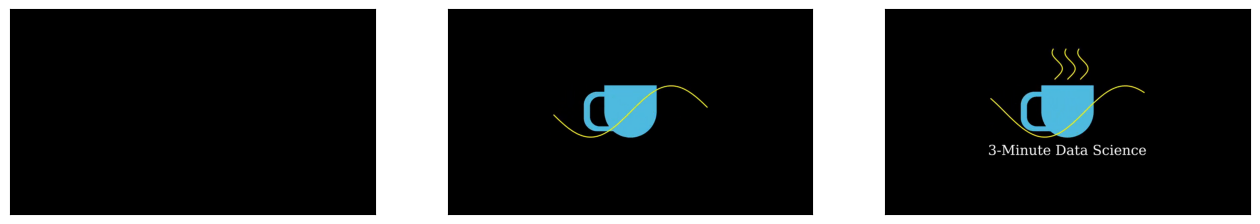

In [85]:
plot_images(images_path=images_path)

In [76]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

In [ ]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_KEY, max_new_tokens=3000
)

In [84]:
qa_tmpl_str = (
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [ ]:
import json

context_str = "".join(text)
metadata_str = json.dumps(video_metadata)

In [80]:
image_documents = SimpleDirectoryReader(input_files=images_path).load_data()

In [81]:
response = openai_mm_llm.complete(
    prompt = qa_tmpl_str.format(context_str, metadata_str, query), image_documents=image_documents
)

In [ ]:
pprint(response.text)

In [83]:
from llama_index.core import PromptTemplate

qa_tmpl = PromptTemplate(qa_tmpl_str.format(metadata_str=video_metadata))

In [ ]:
query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm,
    text_qa_template=qa_tmpl
)

In [ ]:
response = query_engine.query(query_str)

In [ ]:
response